## Create a CSV to Store Model Scores

In [71]:
import pandas as pd
import os

# File to store model performance
performance_file = "database/evaluation_data/model_performance.csv"

# Create file with header if not exists
if not os.path.exists(performance_file):
    pd.DataFrame(columns=["model_name", "MAE", "RMSE", "R2", "notes"]).to_csv(performance_file, index=False)

In [72]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib
from utils.performance_utils import evaluate_and_record

# ========= Data Preparation =========
df = pd.read_csv("database/btc_data/btcusd_1-min_data.csv")
df['Datetime'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df[['Datetime', 'Close']].dropna()
df = df.tail(100_000).reset_index(drop=True)

scaler = MinMaxScaler()
df['scaled_close'] = scaler.fit_transform(df[['Close']])

# Model Training

In [73]:
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(df['scaled_close'].values, window_size=30)

X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

In [74]:
# ========= Train/Test Split =========
split_idx = int(0.9 * len(X_tensor))
X_train, X_test = X_tensor[:split_idx], X_tensor[split_idx:]
y_train, y_test = y_tensor[:split_idx], y_tensor[split_idx:]

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)

In [75]:
# ========= Model Definition =========
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [76]:
class SmallTransformer(nn.Module):
    def __init__(self, input_dim=1, model_dim=32, num_heads=2, num_layers=1, dropout=0.1):
        super().__init__()
        self.embed = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.out = nn.Linear(model_dim, 1)

    def forward(self, x):
        x = self.embed(x)
        x = self.transformer(x)
        return self.out(x[:, -1, :])  # Use last token's output

In [77]:
model = SmallTransformer().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ========= Training =========
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")





Epoch 1/5 - Loss: 2.9620
Epoch 2/5 - Loss: 0.3412
Epoch 3/5 - Loss: 0.2174
Epoch 4/5 - Loss: 0.1814
Epoch 5/5 - Loss: 0.1411


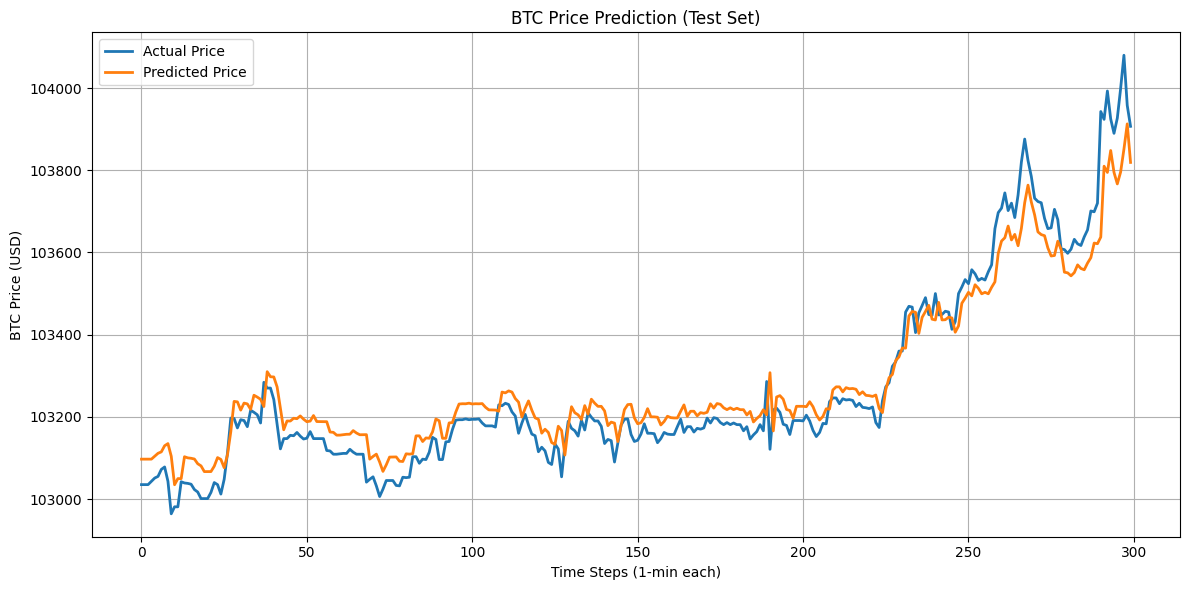

In [78]:
# ========= Prediction Plot =========
model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(device)).squeeze().cpu().numpy()
    y_true = y_test.squeeze().cpu().numpy()

y_pred_unscaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true_unscaled = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 6))
plt.plot(y_true_unscaled[:300], label='Actual Price', linewidth=2)
plt.plot(y_pred_unscaled[:300], label='Predicted Price', linewidth=2)
plt.title('BTC Price Prediction (Test Set)')
plt.xlabel('Time Steps (1-min each)')
plt.ylabel('BTC Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
# ========= Save Artifacts =========
torch.save(model.state_dict(), "utils/saved_models/btc_transformer_model.pth")
joblib.dump(scaler, "utils/saved_models/btc_scaler.pkl")


['utils/saved_models/btc_scaler.pkl']

In [ ]:
# ========= Evaluate and Log =========
mae, rmse, r2 = evaluate_and_record(
    model=model,
    val_loader=val_loader,
    device=device,
    model_name="SmallTransformer_v1",
    scaler=scaler,
    notes="1-layer, 32-dim, 2-heads, 5 epochs, 1 feature",
    save_preds=True
)

print(f"\n📊 MAE={mae:.4f} | RMSE={rmse:.4f} | R²={r2:.4f}")

✅ Logged performance for: SmallTransformer_v1

📊 MAE=133.1880 | RMSE=169.1813 | R²=0.9413


# Lets improve prediction Accuracy
## Lets use multiple input features for better prediction accuracy

In [105]:
import pandas as pd

df = pd.read_csv("database/btc_data/btcusd_1-min_data.csv")

# Convert UNIX timestamp to datetime
df["time"] = pd.to_datetime(df["Timestamp"], unit="s")

# Sort (if needed)
df = df.sort_values("time").reset_index(drop=True)

# Set index (optional)
df.set_index("time", inplace=True)

In [106]:
df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
df["ma_5"] = df["Close"].rolling(5).mean()
df["vol_5"] = df["Close"].rolling(5).std()

In [107]:
df = df.dropna().reset_index()

features = ["Close", "log_return", "ma_5", "vol_5"]

In [108]:
# Convert Timestamp → datetime if not already done
df["time"] = pd.to_datetime(df["Timestamp"], unit="s")

# Get 90 days before the last timestamp
cutoff = df["time"].max() - pd.Timedelta(days=90)

# Filter the DataFrame
df = df[df["time"] >= cutoff].reset_index(drop=True)

print(f"📊 Kept {len(df):,} rows (last 90 days).")

📊 Kept 128,441 rows (last 90 days).


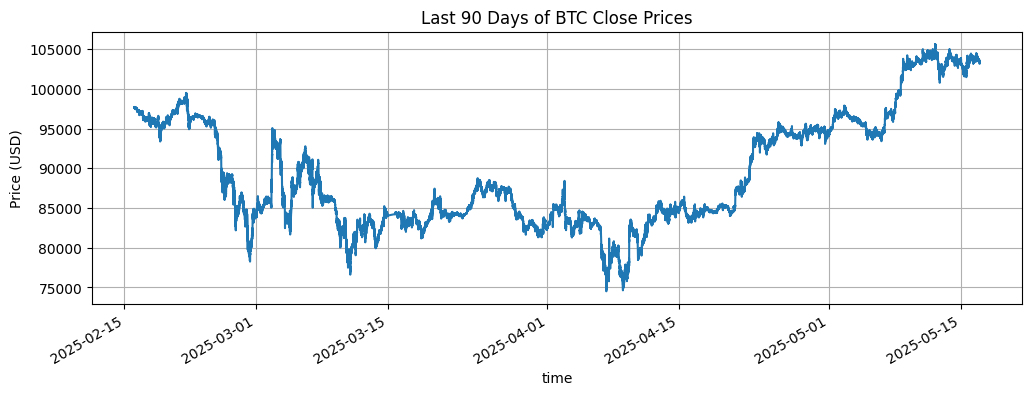

In [109]:
import matplotlib.pyplot as plt

df.set_index("time")["Close"].plot(figsize=(12, 4), title="Last 90 Days of BTC Close Prices")
plt.ylabel("Price (USD)")
plt.grid()
plt.show()

In [110]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

In [111]:
import numpy as np

def create_sequences_multivariate(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size, 0])  # Predict next 'Close'
    return np.array(X), np.array(y)

X, y = create_sequences_multivariate(df_scaled.values, window_size=30)

In [112]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Set device
device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)
print(f"Using device: {device}")

# Convert tensors (no unsqueeze!)
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1).to(device)

# Create dataset and loader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

Using device: mps


## Implementing Positional Encoding 

In [113]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, model_dim, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, model_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / model_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, model_dim)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class SmallTransformer(nn.Module):
    def __init__(self, input_dim, model_dim=64, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=128,
            dropout=dropout,
            batch_first=True  # [B, T, D]
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_layer = nn.Linear(model_dim, 1)

    def forward(self, x):  # x: [B, T, input_dim]
        x = self.input_proj(x)         # → [B, T, model_dim]
        x = self.pos_encoder(x)        # add positional info
        x = self.transformer_encoder(x)  # → [B, T, model_dim]
        x = x[:, -1, :]                # use the last time step
        return self.output_layer(x)   # → [B, 1]

In [114]:
model = SmallTransformer(
    input_dim=X.shape[2],  # e.g. 4 features
    model_dim=64,
    num_heads=4,
    num_layers=2
).to(device)

output = model(X_tensor[:1])  # Should return shape: [1, 1]

## Evaluation

In [115]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_tensor.cpu(), y_tensor.cpu(), test_size=0.2, shuffle=False
)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [116]:
model = SmallTransformer(input_dim=X.shape[2]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

### 🔁 Enhanced Transformer Training Loop

This training loop includes:

✅ **Early Stopping** — stops training when validation loss stops improving  
✅ **MAE & RMSE tracking** — monitors accuracy beyond just MSE  
✅ **tqdm Progress Bar** — live ETA and loss per batch  

📟 **Training on device:** `cuda` (GPU) if available, else `mps` (Apple Silicon), else fallback to `cpu`.

The best model is saved to `best_model.pth` whenever validation loss improves.

In [117]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import numpy as np

def train_model(
    model, train_loader, val_loader, optimizer, criterion,
    epochs=50, patience=5, min_delta=1e-4
):
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_losses = []
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for xb, yb in loop:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            loop.set_postfix(train_loss=np.mean(train_losses))

        avg_train_loss = np.mean(train_losses)

        # === Validation Phase ===
        model.eval()
        val_losses, y_true, y_pred = [], [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_losses.append(loss.item())

                y_true.extend(yb.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        avg_val_loss = np.mean(val_losses)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)

        print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.6f} | "
              f"Val Loss: {avg_val_loss:.6f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

        # === Early Stopping Check ===
        if avg_val_loss + min_delta < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "utils/saved_models/best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break

In [118]:
train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50)

# Save final model
torch.save(model.state_dict(), "utils/saved_models/transformer_multifeature.pth")

Epoch 01 | Train Loss: 0.003276 | Val Loss: 0.001052 | MAE: 0.0252 | RMSE: 0.0324


Epoch 02 | Train Loss: 0.000345 | Val Loss: 0.000308 | MAE: 0.0129 | RMSE: 0.0175


Epoch 03 | Train Loss: 0.000172 | Val Loss: 0.000198 | MAE: 0.0113 | RMSE: 0.0141


Epoch 04 | Train Loss: 0.000099 | Val Loss: 0.000189 | MAE: 0.0101 | RMSE: 0.0138


Epoch 05 | Train Loss: 0.000067 | Val Loss: 0.000156 | MAE: 0.0104 | RMSE: 0.0125


Epoch 06 | Train Loss: 0.000050 | Val Loss: 0.000139 | MAE: 0.0095 | RMSE: 0.0118


Epoch 07 | Train Loss: 0.000041 | Val Loss: 0.000167 | MAE: 0.0113 | RMSE: 0.0129


Epoch 08 | Train Loss: 0.000034 | Val Loss: 0.000068 | MAE: 0.0060 | RMSE: 0.0082


Epoch 09 | Train Loss: 0.000029 | Val Loss: 0.000155 | MAE: 0.0104 | RMSE: 0.0125


Epoch 10 | Train Loss: 0.000025 | Val Loss: 0.000028 | MAE: 0.0049 | RMSE: 0.0053


Epoch 11 | Train Loss: 0.000023 | Val Loss: 0.000114 | MAE: 0.0082 | RMSE: 0.0107


Epoch 12 | Train Loss: 0.000021 | Val Loss: 0.000106 | MAE: 0.0080 | RMSE: 0.0103


Epoch 13 | Train Loss: 0.000019 | Val Loss: 0.000099 | MAE: 0.0075 | RMSE: 0.0099
⏹️ Early stopping at epoch 13


## Best Model Evaluation

In [119]:
joblib.dump(scaler, "utils/saved_models/best_model_scaler.pkl")
model.load_state_dict(torch.load("utils/saved_models/best_model.pth"))
model.eval()

/var/folders/ns/mp2t798n28l81cvv4hpmdpyr0000gn/T/ipykernel_1396/3816461614.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("utils/saved_

SmallTransformer(
  (input_proj): Linear(in_features=4, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [120]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        y_true.extend(yb.numpy())
        y_pred.extend(preds)

y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

In [121]:
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print(f"🧪 MAE: {mae:.4f}")
print(f"📏 RMSE: {rmse:.4f}")
print(f"📈 R² Score: {r2:.4f}")

🧪 MAE: 0.0060
📏 RMSE: 0.0082
📈 R² Score: 0.9958


## Plotting Actual Vs Predicted Prices

/var/folders/ns/mp2t798n28l81cvv4hpmdpyr0000gn/T/ipykernel_1396/139198218.py:11: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/envs/data605_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


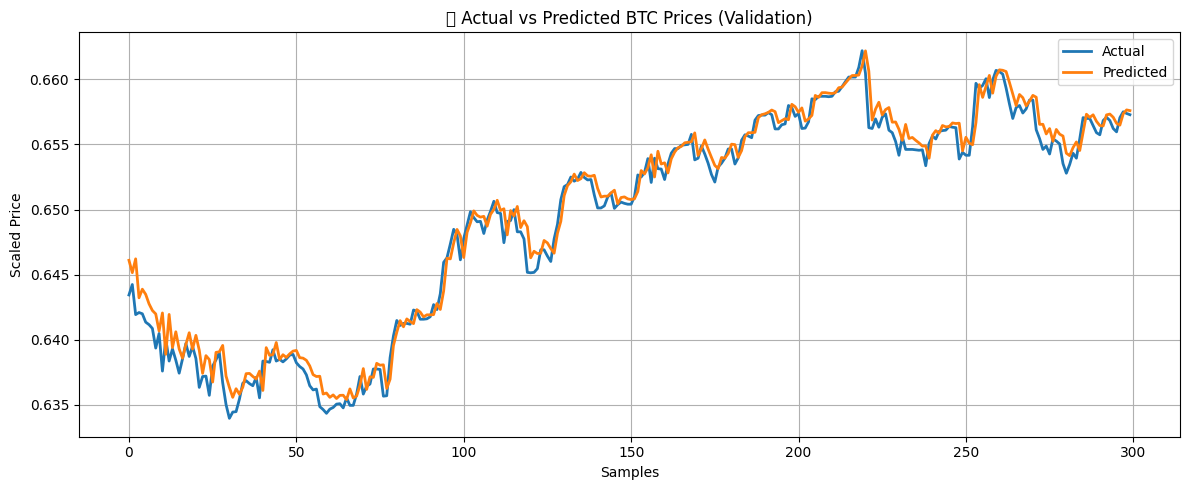

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_true[:300], label="Actual", linewidth=2)
plt.plot(y_pred[:300], label="Predicted", linewidth=2)
plt.title("🔮 Actual vs Predicted BTC Prices (Validation)")
plt.xlabel("Samples")
plt.ylabel("Scaled Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [123]:
new_result = {
    "model_name": "transformer_multifeature",
    "MAE": round(mae, 6),
    "RMSE": round(rmse, 6),
    "R2": round(r2, 6),
    "notes": "2-layer, 64-dim, 4-heads, 50 epochs, 4 features"
}

performance_file = "database/evaluation_data/model_performance.csv"
perf_df = pd.read_csv(performance_file)
new_row = pd.DataFrame([new_result])
perf_df = pd.concat([perf_df, new_row], ignore_index=True)
perf_df.to_csv(performance_file, index=False)

In [125]:
from utils.performance_utils import print_all_performances
print_all_performances()


📊 Model Performance Comparison:
              model_name        MAE       RMSE       R2                                           notes
transformer_multifeature   0.005961   0.008217 0.995835 2-layer, 64-dim, 4-heads, 50 epochs, 4 features
     SmallTransformer_v1 133.187972 169.181338 0.941268   1-layer, 32-dim, 2-heads, 5 epochs, 1 feature


# Model 3

In [145]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# === Load BTC 1-minute data ===
df = pd.read_csv("database/btc_data/btcusd_1-min_data.csv")
df['Datetime'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df[['Datetime', 'Close', 'Volume']].dropna().copy()
# Take only the last 90 days (≈129,600 rows)
df = df.tail(129_600).reset_index(drop=True)

# === Feature Engineering ===
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
df['ma_5'] = df['Close'].rolling(window=5).mean()
df['rsi_14'] = 100 - (100 / (1 + df['Close'].pct_change().rolling(14).mean() /
                              df['Close'].pct_change().rolling(14).std()))
df = df.dropna().reset_index(drop=True)

# === Scale Features ===
scaler = MinMaxScaler()
feature_cols = ['Close', 'log_return', 'ma_5', 'rsi_14', 'Volume']
scaled_features = scaler.fit_transform(df[feature_cols])
df_scaled = pd.DataFrame(scaled_features, columns=feature_cols)
df_scaled['Datetime'] = df['Datetime']

In [146]:
import numpy as np

def create_multistep_sequences(data, window_size=30, forecast_horizon=30):
    """
    Generate (X, y) pairs where:
    - X: shape (num_samples, window_size, num_features)
    - y: shape (num_samples, forecast_horizon) for multi-step prediction
    """
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon):
        seq_x = data[i:i + window_size]
        seq_y = data[i + window_size:i + window_size + forecast_horizon, 0]  # target = Close only
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Convert scaled dataframe to NumPy
sequence_data = df_scaled[["Close", "log_return", "ma_5", "rsi_14", "Volume"]].values

# Create sequences
X, y = create_multistep_sequences(sequence_data, window_size=30, forecast_horizon=30)

# Final shapes
print("✅ Input shape (X):", X.shape)   # (num_samples, 30, 5)
print("✅ Target shape (y):", y.shape)  # (num_samples, 30)

✅ Input shape (X): (129455, 30, 5)
✅ Target shape (y): (129455, 30)


In [147]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Set device
device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Train/Val split
split_idx = int(0.9 * len(X_tensor))
X_train, X_val = X_tensor[:split_idx], X_tensor[split_idx:]
y_train, y_val = y_tensor[:split_idx], y_tensor[split_idx:]

# Create Datasets
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

print("✅ Data ready:")
print("Train batches:", len(train_loader), "  Val batches:", len(val_loader))
print("Train input shape:", X_train.shape)
print("Train target shape:", y_train.shape)

✅ Data ready:
Train batches: 1821   Val batches: 203
Train input shape: torch.Size([116509, 30, 5])
Train target shape: torch.Size([116509, 30])


In [148]:
import torch.nn as nn

class MultiStepTransformer(nn.Module):
    def __init__(self, input_dim=5, model_dim=64, num_heads=4, num_layers=2, dropout=0.1, forecast_horizon=30):
        super().__init__()
        self.embed = nn.Linear(input_dim, model_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=128,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output = nn.Linear(model_dim, forecast_horizon)  # predict 30 steps directly

    def forward(self, x):
        # x: [batch, 30, input_dim]
        x = self.embed(x)             # [batch, 30, model_dim]
        x = self.transformer(x)       # [batch, 30, model_dim]
        x = x[:, -1, :]               # use last time step's representation
        return self.output(x)         # [batch, 30]

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import numpy as np

def train_model(model, train_loader, val_loader, optimizer, device, epochs=20, patience=5):
    best_val_loss = float('inf')
    wait = 0

    for epoch in range(epochs):
        model.train()
        train_losses = []

        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = F.mse_loss(preds, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)

        # Validation
        model.eval()
        val_losses = []
        all_preds, all_targets = [], []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = F.mse_loss(preds, yb)
                val_losses.append(loss.item())
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(yb.cpu().numpy())

        avg_val_loss = np.mean(val_losses)
        mae = mean_absolute_error(all_targets, all_preds)
        rmse = mean_squared_error(all_targets, all_preds, squared=False)

        print(f"Epoch {epoch+1}: 🟢 Train Loss={avg_train_loss:.4f} | 🔵 Val Loss={avg_val_loss:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f}")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            wait = 0
            torch.save(model.state_dict(), "utils/saved_models/30step_transformer.pth")
            joblib.dump(scaler, "utils/saved_models/30step_scaler.pkl")
        else:
            wait += 1
            if wait >= patience:
                print("⏹️ Early stopping triggered.")
                break

In [151]:
model = MultiStepTransformer(input_dim=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_model(model, train_loader, val_loader, optimizer, device, epochs=20, patience=5)

Epoch 1: 🟢 Train Loss=0.0025 | 🔵 Val Loss=0.0007 | MAE=0.0238 | RMSE=0.0256


Epoch 2: 🟢 Train Loss=0.0001 | 🔵 Val Loss=0.0007 | MAE=0.0245 | RMSE=0.0259


Epoch 3: 🟢 Train Loss=0.0001 | 🔵 Val Loss=0.0004 | MAE=0.0190 | RMSE=0.0204


Epoch 4: 🟢 Train Loss=0.0001 | 🔵 Val Loss=0.0003 | MAE=0.0154 | RMSE=0.0167


Epoch 5: 🟢 Train Loss=0.0001 | 🔵 Val Loss=0.0002 | MAE=0.0120 | RMSE=0.0135


Epoch 6: 🟢 Train Loss=0.0001 | 🔵 Val Loss=0.0003 | MAE=0.0165 | RMSE=0.0177


Epoch 7: 🟢 Train Loss=0.0001 | 🔵 Val Loss=0.0002 | MAE=0.0127 | RMSE=0.0141


Epoch 8: 🟢 Train Loss=0.0001 | 🔵 Val Loss=0.0002 | MAE=0.0117 | RMSE=0.0132


Epoch 9: 🟢 Train Loss=0.0001 | 🔵 Val Loss=0.0001 | MAE=0.0098 | RMSE=0.0113


Epoch 10: 🟢 Train Loss=0.0001 | 🔵 Val Loss=0.0008 | MAE=0.0262 | RMSE=0.0273


Epoch 11: 🟢 Train Loss=0.0001 | 🔵 Val Loss=0.0002 | MAE=0.0132 | RMSE=0.0147


Epoch 12: 🟢 Train Loss=0.0001 | 🔵 Val Loss=0.0002 | MAE=0.0127 | RMSE=0.0143


Epoch 13: 🟢 Train Loss=0.0001 | 🔵 Val Loss=0.0007 | MAE=0.0257 | RMSE=0.0268


Epoch 14: 🟢 Train Loss=0.0001 | 🔵 Val Loss=0.0003 | MAE=0.0163 | RMSE=0.0176
⏹️ Early stopping triggered.


In [ ]:
import os
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_multistep_model(model, val_loader, device, scaler, model_name, notes="", save_preds=True):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(yb.cpu().numpy())

    # Inverse transform Close prices only
    y_true_unscaled, y_pred_unscaled = [], []
    for t, p in zip(all_targets, all_preds):
        t_pad = np.zeros((len(t), scaler.n_features_in_))
        p_pad = np.zeros((len(p), scaler.n_features_in_))
        t_pad[:, 0] = t
        p_pad[:, 0] = p
        y_true_unscaled.append(scaler.inverse_transform(t_pad)[:, 0])
        y_pred_unscaled.append(scaler.inverse_transform(p_pad)[:, 0])

    y_true_unscaled = np.array(y_true_unscaled).flatten()
    y_pred_unscaled = np.array(y_pred_unscaled).flatten()

    # Compute metrics
    mae = mean_absolute_error(y_true_unscaled, y_pred_unscaled)
    rmse = mean_squared_error(y_true_unscaled, y_pred_unscaled, squared=False)
    r2 = r2_score(y_true_unscaled, y_pred_unscaled)

    print(f"📊 MAE: {mae:.4f}  |  RMSE: {rmse:.4f}  |  R²: {r2:.4f}")

    # Log results
    log_path = "database/evaluation_data/model_performance.csv"
    new_result = pd.DataFrame([{
        "model_name": model_name,
        "MAE": round(mae, 6),
        "RMSE": round(rmse, 6),
        "R2": round(r2, 6),
        "notes": notes
    }])

    if os.path.exists(log_path):
        df_log = pd.read_csv(log_path)
        df_log = pd.concat([df_log, new_result], ignore_index=True)
    else:
        df_log = new_result

    df_log.to_csv(log_path, index=False)


    return mae, rmse, r2

In [141]:
mae, rmse, r2 = evaluate_multistep_model(
    model=model,
    val_loader=val_loader,
    device=device,
    scaler=scaler,
    model_name="MultiStepTransformer_30min",
    notes="5 features | 30-min ahead | 90-day data"
)

📊 MAE: 610.2636  |  RMSE: 651.4507  |  R²: 0.7538


### Manual Hyper Parameter Tuning

In [142]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from utils.performance_utils import evaluate_and_record as evaluate_multistep_model

class MultiStepTransformer(nn.Module):
    def __init__(self, input_dim=5, model_dim=64, num_heads=4, num_layers=2, dropout=0.1, forecast_horizon=30):
        super().__init__()
        self.embed = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=128,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output = nn.Linear(model_dim, forecast_horizon)

    def forward(self, x):
        x = self.embed(x)
        x = self.transformer(x)
        return self.output(x[:, -1, :])  # use last time step

def train_model(model, train_loader, val_loader, optimizer, device, epochs=20, patience=3):
    best_val_loss = float('inf')
    wait = 0

    for epoch in range(epochs):
        model.train()
        train_losses = []

        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = F.mse_loss(preds, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = F.mse_loss(preds, yb)
                val_losses.append(loss.item())
        avg_val_loss = np.mean(val_losses)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            wait = 0
            torch.save(model.state_dict(), "utils/saved_models/best_model.pth")
        else:
            wait += 1
            if wait >= patience:
                break

def run_experiment(config, train_loader, val_loader, device, scaler):
    model = MultiStepTransformer(
        input_dim=5,
        model_dim=config['model_dim'],
        num_heads=config['num_heads'],
        num_layers=config['num_layers'],
        dropout=config['dropout']
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

    train_model(model, train_loader, val_loader, optimizer, device, epochs=config['epochs'], patience=3)

    mae, rmse, r2 = evaluate_multistep_model(
        model=model,
        val_loader=val_loader,
        device=device,
        scaler=scaler,
        model_name=config['name'],
        notes=config['notes']
    )

    return mae, rmse, r2


In [143]:

# Define 3 configs
configs = [
    {
        "name": "Transformer_d32_h2_l1",
        "model_dim": 32, "num_heads": 2, "num_layers": 1, "dropout": 0.1,
        "lr": 1e-3, "epochs": 10,
        "notes": "dim=32 | heads=2 | layers=1 | 90d"
    },
    {
        "name": "Transformer_d64_h4_l2",
        "model_dim": 64, "num_heads": 4, "num_layers": 2, "dropout": 0.1,
        "lr": 1e-3, "epochs": 10,
        "notes": "dim=64 | heads=4 | layers=2 | 90d"
    },
    {
        "name": "Transformer_d128_h4_l3",
        "model_dim": 128, "num_heads": 4, "num_layers": 3, "dropout": 0.2,
        "lr": 5e-4, "epochs": 10,
        "notes": "dim=128 | heads=4 | layers=3 | 90d"
    }
]

# Run and record
results = []
for config in configs:
    print(f"\n🚀 Running: {config['name']}")
    mae, rmse, r2 = run_experiment(config, train_loader, val_loader, device, scaler)
    results.append((config['name'], mae, rmse, r2))

# Show summary
print("\n✅ Experiment Summary:")
for name, mae, rmse, r2 in results:
    print(f"{name}: MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")


🚀 Running: Transformer_d32_h2_l1


✅ Logged performance for: Transformer_d32_h2_l1

🚀 Running: Transformer_d64_h4_l2


✅ Logged performance for: Transformer_d64_h4_l2

🚀 Running: Transformer_d128_h4_l3


✅ Logged performance for: Transformer_d128_h4_l3

✅ Experiment Summary:
Transformer_d32_h2_l1: MAE=718.7761, RMSE=766.3478, R²=0.6593
Transformer_d64_h4_l2: MAE=923.6802, RMSE=961.3387, R²=0.4639
Transformer_d128_h4_l3: MAE=1134.9645, RMSE=1187.2915, R²=0.1823
